In [1]:
#1

In [2]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [3]:
print(torch.cuda.memory_summary(device=torch.device("cuda")))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [7]:
# Import

!pip install torchvision
!pip install lpips
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

from google.colab import drive

import csv

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import sys
import torch.nn as nn
import yaml
from omegaconf import OmegaConf

from torch.optim import Adam
import torch.nn.functional as F

from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DiTPipeline, DDIMScheduler

from torch import nn, optim

from torch.nn.utils import clip_grad_norm_

from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO

from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image

import os

from torch.optim.lr_scheduler import ReduceLROnPlateau
import lpips

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class DatasetCVUSA(Dataset):
    def __init__(self, list_path, root_dir, transform_ground=None, transform_sat=None):
        self.root_dir = root_dir
        self.transform_ground = transform_ground
        self.transform_sat = transform_sat

        self.image_ids = []

        with open(list_path, "r") as f:
            reader = csv.reader(f, delimiter=',')
            for row in reader:
                streetview_path = row[1]
                filename = os.path.basename(streetview_path)
                if filename.startswith("input"):
                    filename = filename[len("input"):]
                image_id = os.path.splitext(filename)[0]
                self.image_ids.append(image_id)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        ground_path = os.path.join(self.root_dir, "streetview", f"{image_id}.jpg")
        sat_path = os.path.join(self.root_dir, "bingmap", f"input{image_id}.png")

        ground_img = Image.open(ground_path).convert("RGB")
        sat_img = Image.open(sat_path).convert("RGB")

        if self.transform_ground:
            ground_img = self.transform_ground(ground_img)
        if self.transform_sat:
            sat_img = self.transform_sat(sat_img)

        return ground_img, sat_img


In [9]:

IMG_SIZE = 256

transform_rgb = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_seg = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

dataset_root = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA"
split_file = os.path.join(dataset_root, "train-19zl.csv")
split_file_val = os.path.join(dataset_root, "val-19zl.csv")

val_dataset = DatasetCVUSA(
    root_dir=dataset_root,
    list_path=split_file_val,
    transform_ground=transform_rgb,
    transform_sat=transform_rgb
)

cvusa_dataset = DatasetCVUSA(
    root_dir=dataset_root,
    list_path=split_file,
    transform_ground=transform_rgb,
    transform_sat=transform_rgb
)

In [12]:
def load_checkpoint(unet, optimizer, scheduler, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    unet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    projection.load_state_dict(checkpoint['projection_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    return start_epoch

In [13]:
def train_cvusa_loop(
    dataloader,
    unet,
    vae,
    clip_model,
    clip_processor,
    scheduler,
    device,
    epochs=10,
    lr=1e-5,
    checkpoint_dir='./checkpoints',
    input_image_path="/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/streetview/0000008.jpg",
    output_image_dir='./outputs',
    resume_path= "/content/drive/MyDrive/unet_checkpoint_epoch40.pth"
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(output_image_dir, exist_ok=True)

    unet.train()
    vae.eval()
    clip_model.train()

    l_recon = 1.0
    l_clip  = 2.0

    lr_base = 1e-5
    lr_clip = 1e-6
    # Projection from CLIP to SD
    projection = nn.Sequential(
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 768),
    ).to(device)

    params = [
        {"params": unet.parameters(),      "lr": lr_base},
        {"params": projection.parameters(), "lr": lr_base},
        {"params": filter(lambda p: p.requires_grad, clip_model.parameters()), "lr": lr_clip},
    ]

    optimizer = torch.optim.AdamW(params)
    start_epoch = 0
    lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)
    if resume_path is not None:
        checkpoint = torch.load(resume_path, map_location=device)
        unet.load_state_dict(checkpoint['model_state_dict'])
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"✅ Riutilizzato optimizer state da epoch {start_epoch}")
        except ValueError:
            print("Warning: optimizer checkpoint non compatibile con i nuovi param groups. Ripartendo con optimizer pulito.")

        try:
            projection.load_state_dict(checkpoint['projection_state_dict'])
            print("✅ Ripristinata projection dal checkpoint")
        except Exception as e:
            print(f"Warning: projection checkpoint non compatibile. Ripartendo da zero per la projection.")

        start_epoch = checkpoint.get('epoch', 0)

    for epoch in range(start_epoch, start_epoch + epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        n_batches = 0
        running_noise = 0.0
        running_recon = 0.0
        running_clip = 0.0
        running_total = 0.0

        for batch_idx, (ground_img, sat_img) in enumerate(loop):
            ground_img = ground_img.to(device)
            sat_img = sat_img.to(device)

            with torch.no_grad():
                raw_ground_imgs = [to_pil_image(((img.cpu() * 0.5) + 0.5).clamp(0, 1)) for img in ground_img]
                clip_inputs = clip_processor(images=raw_ground_imgs, return_tensors="pt").to(device)
                cond_embed = clip_model.get_image_features(**clip_inputs)

            cond_embed_proj = projection(cond_embed).unsqueeze(1).repeat(1, 77, 1)  # [B, 77, 768]

            with torch.no_grad():
                latents = vae.encode(sat_img).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=device).long()
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=cond_embed_proj).sample

            with torch.no_grad():
                pred_latents = []
                for i in range(noise_pred.shape[0]):
                    step_output = scheduler.step(
                        model_output=noise_pred[i].unsqueeze(0),
                        timestep=timesteps[i],
                        sample=noisy_latents[i].unsqueeze(0)
                    )
                    pred_latents.append(step_output.prev_sample)

                pred_latents = torch.cat(pred_latents, dim=0)
                decoded = vae.decode(pred_latents / 0.18215).sample
                decoded = (decoded.clamp(-1,1)+1)/2
                sat_target = (sat_img.clamp(-1,1)+1)/2

                decoded_lpips = decoded * 2 - 1
                target_lpips  = sat_target * 2 - 1
                loss_recon = lpips_loss_fn(decoded, sat_target).mean()

            with torch.no_grad():
                decoded_pils = [to_pil_image(img.cpu()) for img in decoded]
                target_pils  = [to_pil_image(img.cpu()) for img in sat_target]

                clip_decoded_inputs = clip_processor(images=decoded_pils, return_tensors="pt").to(device)
                clip_target_inputs  = clip_processor(images=target_pils, return_tensors="pt").to(device)

                clip_decoded = clip_model.get_image_features(**clip_decoded_inputs)
                clip_target  = clip_model.get_image_features(**clip_target_inputs)

            loss_clip = 1 - F.cosine_similarity(clip_decoded, clip_target).mean()

            loss = F.mse_loss(noise_pred.float(), noise.float())

            total_loss = loss + l_recon*loss_recon + l_clip*loss_clip

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()

            running_noise += loss.item()
            running_recon += loss_recon.item()
            running_clip  += loss_clip.item()
            running_total += total_loss.item()
            n_batches    += 1

            loop.set_postfix(total_loss=total_loss)

        checkpoint_path = os.path.join(checkpoint_dir, f'unet_checkpoint_epoch{epoch+1}.pth')
        torch.save({
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'projection_state_dict': projection.state_dict(),
            'epoch': epoch + 1,
            'batch': batch_idx
        }, checkpoint_path)

        if input_image_path is not None:
            with torch.no_grad():
                input_image = Image.open(input_image_path).convert("RGB")
                transform = transforms.Compose([
                    transforms.Resize((ground_img.shape[-2], ground_img.shape[-1])),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
                ])
                input_tensor = transform(input_image).unsqueeze(0).to(device)

                clip_inputs = clip_processor(images=[input_image], return_tensors="pt").to(device)
                cond_embed = clip_model.get_image_features(**clip_inputs)
                cond_embed_proj = projection(cond_embed).unsqueeze(1).repeat(1, 77, 1)


                latent = torch.randn(1, 4, sat_img.shape[-2] // 8, sat_img.shape[-1] // 8).to(device)

                for t in reversed(range(scheduler.config.num_train_timesteps)):
                    latent_model_input = scheduler.scale_model_input(latent, t)
                    noise_pred = unet(latent_model_input, torch.tensor([t], device=device), encoder_hidden_states=cond_embed_proj).sample
                    latent = scheduler.step(noise_pred, t, latent).prev_sample

                decoded_image = vae.decode(latent / 0.18215).sample
                decoded_image = ((decoded_image.clamp(-1, 1) + 1) / 2).cpu()
                output_pil = to_pil_image(decoded_image[0])

                output_path = os.path.join(output_image_dir, f"generated_epoch{epoch+1}.png")
                output_pil.save(output_path)

        avg_total_loss = running_total / n_batches
        lr_scheduler.step(avg_total_loss)

        print(
          f"Epoch {epoch+1}/{epochs} — "
          f"noise: {running_noise/n_batches:.4f} | "
          f"recon: {running_recon/n_batches:.4f} | "
          f"clip: {running_clip/n_batches:.4f}  | "
          f"total: {avg_total_loss:.4f}"
        )


In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

for param in clip_model.parameters():
    param.requires_grad = False

for name, module in clip_model.named_modules():
    # Cerca i layer .resblocks.10 e .resblocks.11
    if "resblocks.10" in name or "resblocks.11" in name:
        for p in module.parameters():
            p.requires_grad = True

scheduler = DDPMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)

cvusa_loader = DataLoader(cvusa_dataset, batch_size=8, shuffle=True, num_workers=10)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [15]:

train_cvusa_loop(
    dataloader=cvusa_loader,
    unet=unet,
    vae=vae,
    clip_model=clip_model,
    clip_processor=clip_processor,
    scheduler=scheduler,
    device=device,
    epochs=5
)

⚠️ Warning: optimizer checkpoint non compatibile con i nuovi param groups. Ripartendo con optimizer pulito.
⚠️ Warning: projection checkpoint non compatibile. Ripartendo da zero per la projection.


Epoch 41/5: 100%|██████████| 831/831 [10:52<00:00,  1.27it/s, total_loss=tensor(1.6005, device='cuda:0', grad_fn=<AddBackward0>)]


Epoch 41/5 — noise: 0.1781 | recon: 0.6186 | clip: 0.3966  | total: 1.5899


Epoch 42/5: 100%|██████████| 831/831 [07:03<00:00,  1.96it/s, total_loss=tensor(1.7187, device='cuda:0', grad_fn=<AddBackward0>)]


Epoch 42/5 — noise: 0.1762 | recon: 0.6199 | clip: 0.3979  | total: 1.5920


Epoch 43/5: 100%|██████████| 831/831 [07:03<00:00,  1.96it/s, total_loss=tensor(1.5928, device='cuda:0', grad_fn=<AddBackward0>)]


Epoch 43/5 — noise: 0.1775 | recon: 0.6187 | clip: 0.3973  | total: 1.5909


Epoch 44/5: 100%|██████████| 831/831 [07:03<00:00,  1.96it/s, total_loss=tensor(1.5753, device='cuda:0', grad_fn=<AddBackward0>)]


Epoch 44/5 — noise: 0.1783 | recon: 0.6170 | clip: 0.3954  | total: 1.5861


Epoch 45/5: 100%|██████████| 831/831 [07:03<00:00,  1.96it/s, total_loss=tensor(1.5121, device='cuda:0', grad_fn=<AddBackward0>)]


Epoch 45/5 — noise: 0.1791 | recon: 0.6177 | clip: 0.3957  | total: 1.5882


In [16]:
!cp /content/checkpoints/unet_checkpoint_epoch45.pth /content/drive/MyDrive/

In [ ]:
cp /devi/darmi/errore.pth /content/drive/MyDrive/ ff

In [18]:

import gc
gc.collect()


torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [19]:


model = unet.to(device)
checkpoint = torch.load('/content/drive/MyDrive/unet_checkpoint_epoch45.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


In [ ]:
from diffusers import AutoencoderKL
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPVisionModel

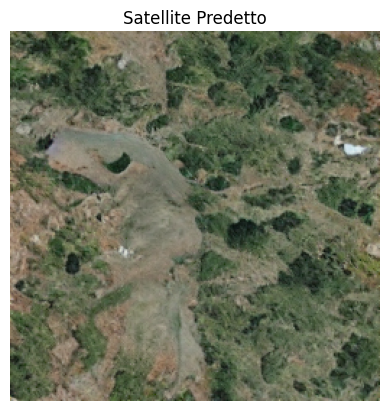

In [23]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.eval()


clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
vae.eval()

transform_rgb = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

ground_img_path = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/streetview/0000008.jpg"
ground_img = Image.open(ground_img_path).convert("RGB")
ground_tensor = transform_rgb(ground_img).unsqueeze(0).to(device)  # shape: [1, 3, 256, 256]

with torch.no_grad():
    clip_inputs = clip_processor(images=ground_img, return_tensors="pt").to(device)
    encoder_hidden_states = clip_model(**clip_inputs).last_hidden_state  # shape [1, 257, 768]


latents = torch.randn((1, 4, 32, 32), device=device)
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
scheduler.set_timesteps(50)  # o 25 bo ora vediamo

with torch.no_grad():
    for t in scheduler.timesteps:
        latent_model_input = latents
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=encoder_hidden_states).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

with torch.no_grad():
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2  # [0, 1]
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]

plt.imshow(image)
plt.axis("off")
plt.title("Satellite Predetto")
plt.show()
